In [1]:
import argparse
import os
import os.path as osp
import sys
from glob import glob
import pandas as pd

In [2]:
retr_path = osp.abspath(osp.join(os.getcwd(), os.pardir, 'retr'))
sys.path.append(
    retr_path
)

In [3]:
import torch
from torch.utils.data import DataLoader
from data_utils import refcoco
from torchvision.transforms import Compose, Lambda
from configuration import Config

In [4]:
config = Config()

In [5]:
ann_dir = osp.join(config.project_path, 'generated/compiled_annotations')
fig_location = osp.join(config.project_path, 'generated/figures')
if not osp.isdir(fig_location):
    os.mkdir(fig_location)

files = sorted(glob(f'{ann_dir}/**'))

In [6]:
all_dfs = {}
for path in files: 
    df = pd.read_csv(path, index_col=0)
    ann_ids = pd.unique(df.ann_id)
    name = osp.split(path)[-1].replace('.csv', '')
    all_dfs[name] = df[['ann_id', 'expression', 'majority_annotation']]

In [7]:
all_dfs[list(all_dfs.keys())[1]]

,ann_id,expression,majority_annotation
idx,,,
0,100002,right chair,F
1,120013,person in black on right,F
2,573794,left sink,F
3,586064,bear on right,A
4,314750,white table,F
...,...,...,...
195,1361813,bike in the middle bottom,A
196,345627,yellow cab,A
197,16996,cat on top,F


In [8]:
args = argparse.Namespace(
    target_noise=0.5,
    use_context=True,
    use_scene_summaries=False,
    dataset='refcoco'
)

config.use_global_features = args.use_context
config.use_scene_summaries = args.use_scene_summaries
config.use_location_features = True

config.prefix = args.dataset
config.ref_dir = osp.join(config.ref_base, config.prefix)
config.checkpoint_path = osp.join(retr_path, 'models', config.prefix)

In [9]:
# build datasets
config.verbose = True
config.use_normalized_paco = True
config.backbone = 'ResNet152'
config.dir = config.coco_dir
config.max_position_embeddings = 128

if 'refcoco' in config.prefix:
    build_dataset = refcoco.build_dataset
elif config.prefix.lower() == 'paco':
    build_dataset = paco.build_dataset
else:
    raise NotImplementedError

dataset = build_dataset(
    config, mode='testb', noise_coverage=args.target_noise)


target_transformation = dataset.target_transform['transform']
target_transformation = Compose(target_transformation.transforms[:-2])
dataset.target_transform['transform'] = target_transformation

print('target_transform: ', dataset.target_transform)

context_transformation = dataset.context_transform['transform']
context_transformation = Compose(context_transformation.transforms[:-2])
dataset.context_transform['transform'] = context_transformation

print('context_transform: ', dataset.context_transform)

dataset.return_tensor = False

using data from refcoco / /home/simeon/Dokumente/Datasets/ReferIt/refcoco
Initialize RefCocoCaption with mode: testb 
target transformation: {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
    CoverWithNoise(noise_coverage=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)} 
context transformation: {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)} 
entries: 5095 
return unique: False 

target_transform:  {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
    CoverWithNoise(noise_coverage=0.5)
)}
context_transform:  {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
)}


In [10]:
_annot_select = [a for a in dataset.annot_select if a[0] in ann_ids]
included_ids = set()
annot_select = []
for a in _annot_select:
    if a[0] in included_ids:
        continue
    annot_select.append(a)
    included_ids.add(a[0])
    
dataset.annot_select = annot_select

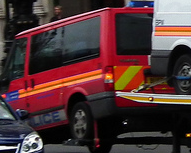

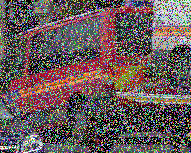

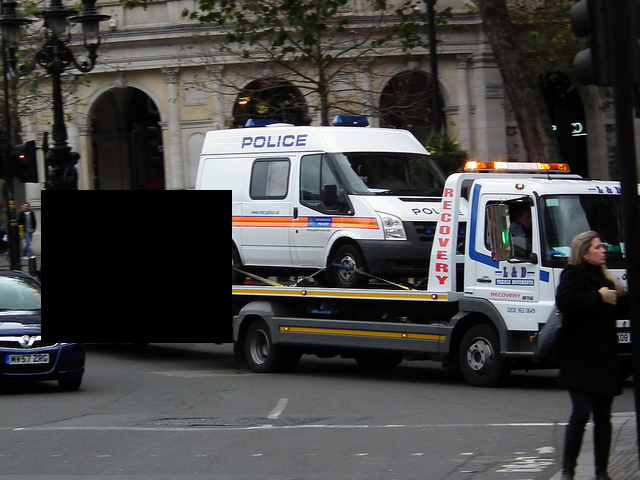

176: red truck
refcoco_testb_trf_global_noise:0-0: red truck (A)
refcoco_testb_trf_global_noise:1-0: white truck (A)
refcoco_testb_trf_nocontext_noise:0-0: red van (A)
refcoco_testb_trf_nocontext_noise:1-0: left elephant (F)
refcoco_testb_trf_scene_noise:0-0: red truck (A)
refcoco_testb_trf_scene_noise:1-0: car on left (A)


In [12]:
idx = 176
ann_id = dataset.annot_select[idx][0]

image, target_image, context_image, caption = dataset.get_imgs_from_ann_id(ann_id)
display(target_image)
display(dataset.target_transform['transform'](target_image))
display(context_image)
print(f'{idx}: {caption}')

for name, df in all_dfs.items():
    entry = df.loc[df.ann_id == ann_id].iloc[0]
    system_expression = entry.expression
    system_eval = entry.majority_annotation
    if 'trf' in name and not '0-5' in name:
        print(f'{name}: {system_expression} ({system_eval})')

In [13]:
ann_id, *encoder_input, caption, cap_mask = dataset.__getitem__(idx)
target_img, context_img, loc_feats = encoder_input

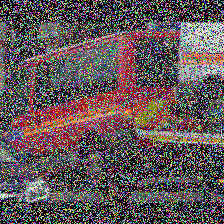

In [14]:
target_img

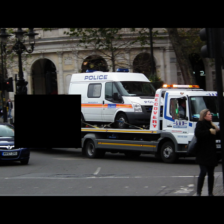

In [15]:
context_img

In [16]:
loc_feats

tensor([0.0643, 0.3966, 0.3623, 0.7161, 0.0952])